## Submissions without individual coursework submission form filled and attached will receive 0 points.

## Feedback

###### 	
Dear Junming, The submission makes some good use of the tools provided in class and you and you find a solution to the problem at hand. You display a significant degree of creativity and originality in completing the assignment. Finally, the overall delivery of the solution is supported by well structured materials. In the following I give some comments on the individual parts: 

- Q1: Could in principle try to make the prediction earlier/at multiple time steps, using a seq-to-seq approach. In which cases could this be sensible? 

- Q2: Should split data at random (unless we are splitting within a time series, which is not the case here). 


- Q3: What model would you go with? Could also consider different types of layers in combination (in particular Conv1D + GRU/LSTM). Could have benefited from automated tuning. - Q4: The answer does not make clear the assumption of translation invariance inherent to Conv1D and the impact this has on the applicability in different cases. The answer does not make clear that Conv1D layers only capture limited order information. 


- Q5: But why exactly can the CNN outperform the RNN here when it comes to training times? The key aspect is that different parts of the picture can be looked at simultaneously, while the RNN proceeds sequentially through the sequence 


- Q8: How do you arrive at this model? Tuning process could have been more systematic. What might be an issue with pre-trained CNNs from a conceptual perspective? - Q9: Missing evaluation of final model choice (after training on combined set).

In [1]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [43]:
with open("gdrive/MyDrive/individual_cw2/time_series_1.pickle", "rb") as handle:
    time_series_1 = pickle.load(handle)
    print("Time series data: ", time_series_1[1])

with open("gdrive/MyDrive/individual_cw2/time_series_2.pickle", "rb") as handle:
    time_series_2 = pickle.load(handle)
    print("Time series data: ", time_series_2[1])

with open("gdrive/MyDrive/individual_cw2/y.pickle", "rb") as handle:
    y = pickle.load(handle)
    print("Labels", y[1])


Time series data:  [31 31 30 ... 37 32 31]
Time series data:  [71 83 81 ...  1  1  1]
Labels 2.0


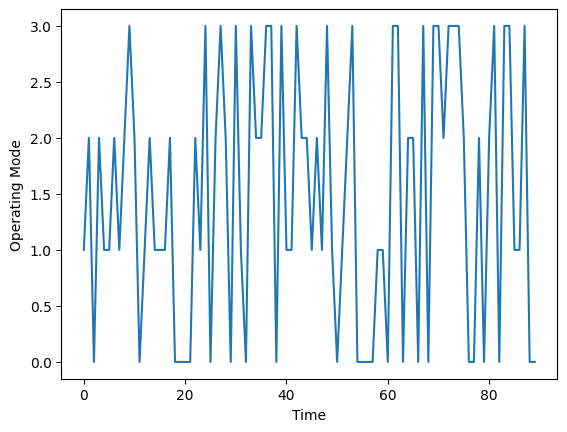

In [44]:
# plot the labels over time
plt.plot(y[10:100])
plt.xlabel("Time")
plt.ylabel("Operating Mode")
plt.show()


## Data discription:

1. Dataset: 4,000 turbine runs with sensor readings and operating modes.

2. Two NumPy arrays: time_series_1 (pitch angle) and time_series_2 (generator torque), both of shape (4000, 5000).

3. Each observation: 5,000 sensor readings from a turbine run.

4. y: operating mode for each turbine run (0: healthy, 1: faulty generator torque, 2: faulty pitch angle, 3: both faulty).

5. Balanced dataset: equal representation of each operating mode.

6. Objective: predict the operating mode of a turbine based on sensor readings.

## Question 1
Discuss what type of sequence prediction approach (sequence-to-vector, sequence-to- sequence, or encoder-decoder) is most sensible to predict the operating mode of a turbine based on the two sensor reading time series. 

Also describe what data shape you need to use for your chosen approach.



The inputs of our data have 4000 sequences each of them contains 5000 fixed-sized time series data points which are used to classify the 4 different turbine status. That is, each of the sequence is mapped to an unique operating model. Thus, the sequence prediction approach is the sequence-to-vector one. The output below is the visualisation of an example time series and its output. 
input: [1.3130192197564614, 0.1833074194197172, 1.349574942752203, 0.288990810328559, 1.269201213964146, 1.1680700438048106] | output: [2.0].

## Question 2

Create an iterator (ideally, a tensorflow.data.Dataset) that produces batches of data formatted in the appropriate way for your chosen approach.

In [45]:
# 60% training, 20% validation, and 20% testing
train_size = int(len(y) * 0.6)
val_size = int(len(y) * 0.2)
test_size = len(y) - train_size - val_size

combined_data_unscaled = np.stack([time_series_1, time_series_2], axis=-1)

# Scale data for each time series 
mean_1 = np.mean(time_series_1[:train_size], axis=0)
std_1 = np.std(time_series_1[:train_size], axis=0)
scaled_time_series_1 = (time_series_1 - mean_1) / std_1

mean_2 = np.mean(time_series_2[:train_size], axis=0)
std_2 = np.std(time_series_2[:train_size], axis=0)
scaled_time_series_2 = (time_series_2 - mean_2) / std_2

# Combine two time series into a shape (4000, 5000, 2)
combined_data = np.stack([scaled_time_series_1, scaled_time_series_2], axis=-1)

print(combined_data.shape)
print(y.shape)
combined_data[1][1], mean_1[1], std_1[1], combined_data[1][1]

(4000, 5000, 2)
(4000,)


(array([2.06582527, 1.48425707]),
 28.25583333333333,
 1.3283633936372814,
 array([2.06582527, 1.48425707]))

In [46]:
# Select the data for training, validation, and testing sets
train_data = combined_data[:train_size]
val_data = combined_data[train_size: train_size + val_size]
test_data = combined_data[train_size + val_size:]
train_labels = y[:train_size]
val_labels = y[train_size: train_size + val_size]
test_labels = y[train_size + val_size:]

# Create the training, validation, and testing datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Batch the datasets
batch_size = 64
train_dataset = train_dataset.shuffle(100).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)
val_dataset = val_dataset.prefetch(1)

train_dataset, test_dataset, train_labels.shape, test_labels.shape, train_data.shape

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5000, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5000, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 (2400,),
 (800,),
 (2400, 5000, 2))

In [47]:
for inputs, targets in train_dataset:
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: (64, 5000, 2)
Target shape: (64,)


In [8]:
for data in [train_dataset, val_dataset]:
    print("Next data set:")

    for inputs, targets in data:
        print("    Next batch:")

        for i in range(targets.shape[0]):
            print(
                "       input:",
                [x for x in inputs[i][1:4].numpy().flatten()],
                "| output:",
                [x for x in targets[i].numpy().flatten()],
            )
            break
        break

Next data set:
    Next batch:
       input: [-0.9453989317596668, 1.701082010967896, -0.985666486667614, -0.149704916925422, -0.20162588092428918, 0.6511772430061479] | output: [0.0]
Next data set:
    Next batch:
       input: [1.3130192197564614, -0.25034246387976244, 1.349574942752203, -0.149704916925422, 1.269201213964146, 0.9096236434054793] | output: [1.0]


In [9]:
for inputs, targets in train_dataset:
    print("Input:", inputs.shape)
    print("Output:", targets.shape)
    break


Input: (64, 5000, 2)
Output: (64,)


In [10]:
# Function for loading trained model and print the test accuracy and plots
def load_model_test(model, log,  test = test_dataset):

    model = tf.keras.models.load_model(model)
    print(f"Test loss of time series: {model.evaluate(test_dataset)[0]:.2f}")
    print(
    f"Test accuracy of time series: {model.evaluate(test_dataset)[1]:.2f}")

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    ax1.set_title("Loss")
    ax1.plot(log.history["loss"], label="train")
    ax1.plot(log.history["val_loss"], label="test")
    ax1.legend()

    ax2.set_title("Accuracy")
    ax2.plot(log.history["accuracy"], label="train")
    ax2.plot(log.history["val_accuracy"], label="test")
    ax2.legend()

    fig.tight_layout()
    plt.show()

    return model

## Question 3

Create a neural network in TensorFlow to predict the operating mode of a wind turbine based on the sensor data. 

Make sure that you try out different layers and elements discussed in class, such as Dense, SimpleRNN, GRU, and Conv1D.

## Question 3 baseline models

1. A simple Dense network

2. A Simple RNN network

3. A simple DRU network

4. A simple Conv1D network


The task goal is to classify each time sequence into a fixed number of classes. Softmax function can do it by converting the previous layer's output into a probability distribution over the output classes, with each value representing the probability of the corresponding class.

Furthermore, in this scenario, the sparse_categorical_crossentropy loss function is applied. When the target variable is not one-hot encoded, here we have target labels 0, 1, 2, and 3. The sparse_categorical_crossentropy function computes the cross-entropy loss between the predicted probability distribution and the true class label for integer-encoded target variables.

In [12]:
sequence_len = 5000
dim = 2

# Create a dense neural network
model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(sequence_len, dim)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)

# Create a SimpleRNN model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Reshape((sequence_len, dim), input_shape=(sequence_len, dim)),
    tf.keras.layers.SimpleRNN(24),
    tf.keras.layers.Dense(4, activation="softmax")
])

# Create a GRU model
model_3 = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(24, input_shape=(sequence_len, dim)),
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)


# Create a Conv1D model
model_4 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=24, kernel_size=3, input_shape=(sequence_len, dim)
        ),

        tf.keras.layers.MaxPooling1D(3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)

model_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# model_1.summary(), model_2.summary(), model_3.summary(), model_4.summary()


In [ ]:
checkpoint_cb_1 = tf.keras.callbacks.ModelCheckpoint(
    "simple_dense", save_best_only=True)

history_1 = model_1.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_cb_1]
)

13/13 [==============================] - 0s 3ms/step - loss: 0.3637 - accuracy: 0.8575
Test loss of time series: 0.36
13/13 [==============================] - 0s 3ms/step - loss: 0.3637 - accuracy: 0.8575
Test accuracy of time series: 0.86


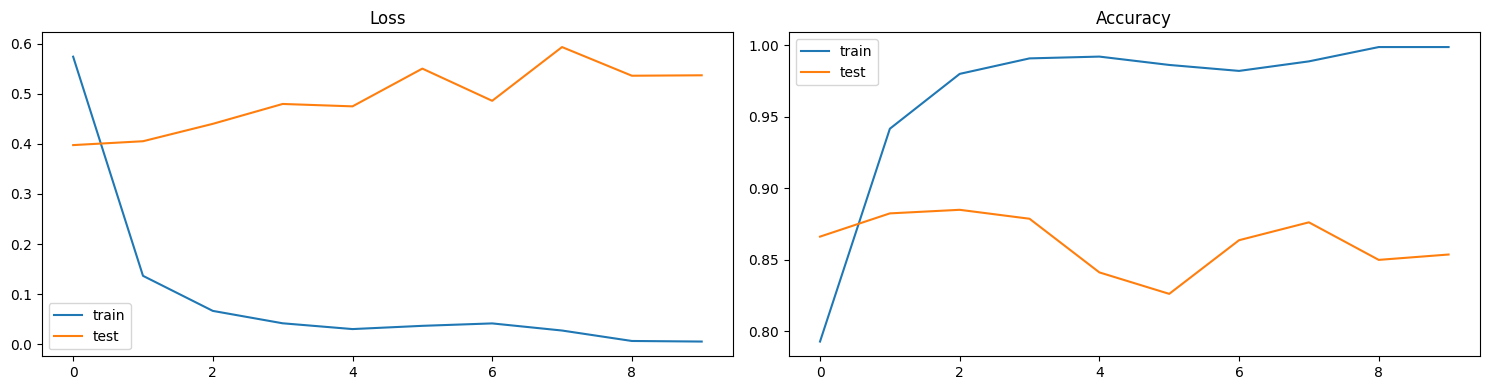

In [242]:
model_1 = load_model_test("simple_dense", history_1)

In [ ]:
checkpoint_cb_2 = tf.keras.callbacks.ModelCheckpoint(
    "simpleRNN_1", save_best_only=True)

history_2 = model_2.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_cb_2]
)

13/13 [==============================] - 3s 182ms/step - loss: 1.0870 - accuracy: 0.4913
Test loss of time series: 1.09
13/13 [==============================] - 2s 183ms/step - loss: 1.0870 - accuracy: 0.4913
Test accuracy of time series: 0.49


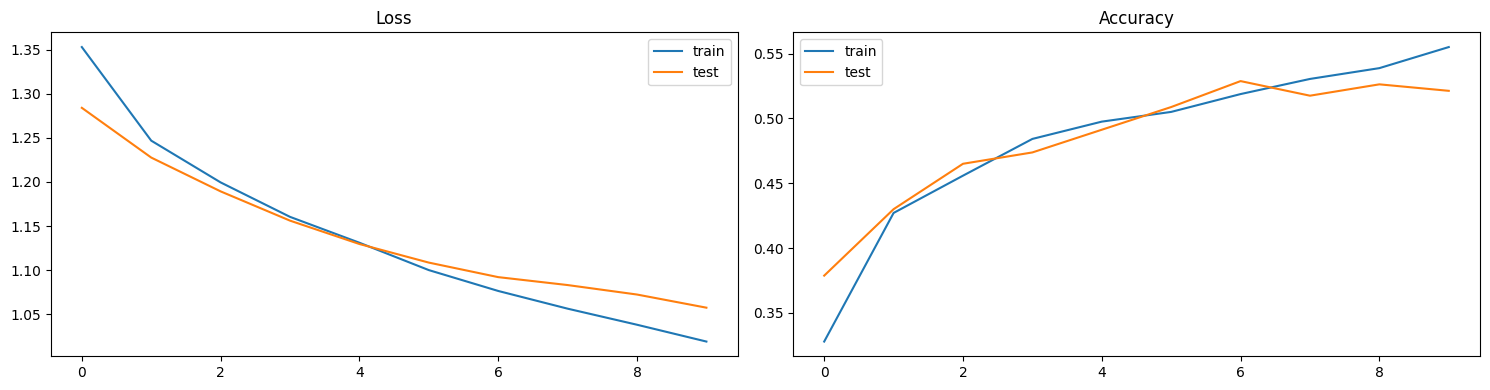

In [126]:
model_2 = load_model_test("simpleRNN_1", history_2)

In [ ]:
checkpoint_cb_3 = tf.keras.callbacks.ModelCheckpoint(
    "simple_GRU", save_best_only=True)

history_3 = model_3.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_cb_3]
)

13/13 [==============================] - 5s 324ms/step - loss: 1.2089 - accuracy: 0.4175
Test loss of time series: 1.21
13/13 [==============================] - 4s 323ms/step - loss: 1.2089 - accuracy: 0.4175
Test accuracy of time series: 0.42


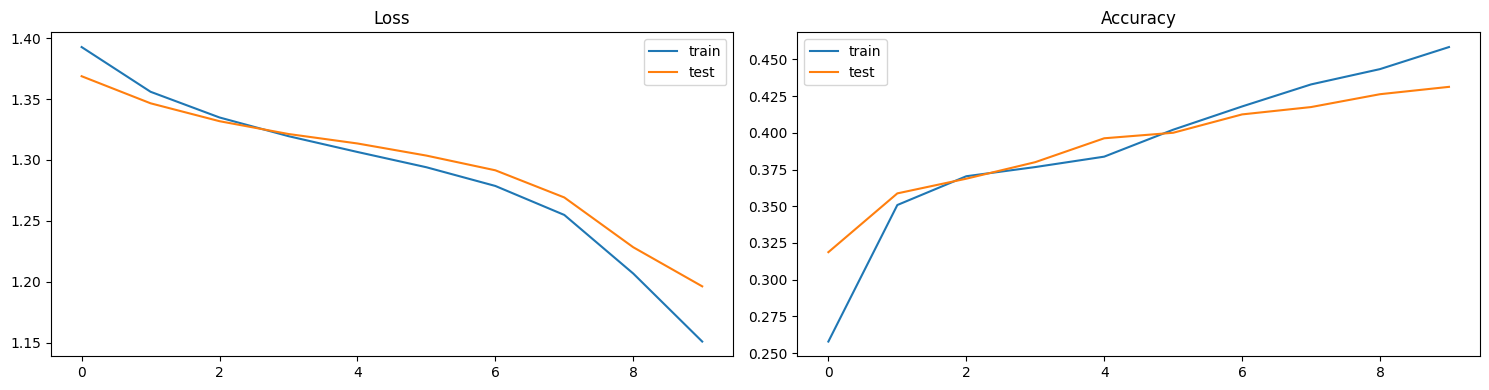

In [128]:
model_3 = load_model_test("simple_GRU", history_3)

In [ ]:
checkpoint_cb_4 = tf.keras.callbacks.ModelCheckpoint(
    "simple_Conv1D", save_best_only=True)

history_4 = model_4.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_cb_4]
)

13/13 [==============================] - 0s 5ms/step - loss: 0.3542 - accuracy: 0.8413
Test loss of time series: 0.35
13/13 [==============================] - 0s 5ms/step - loss: 0.3542 - accuracy: 0.8413
Test accuracy of time series: 0.84


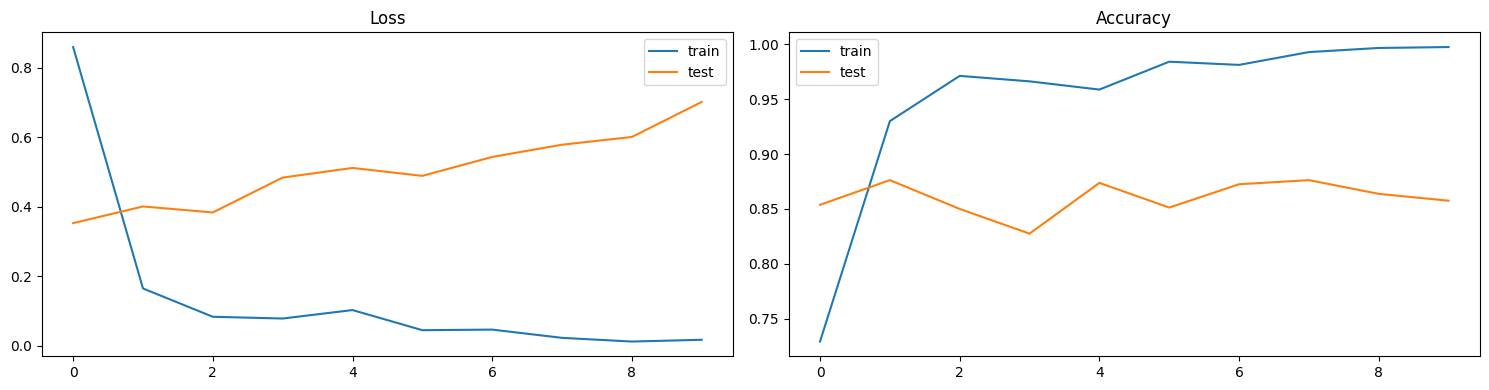

In [17]:
model_4 = load_model_test("simple_Conv1D", history_4)

## Complex models for beating the baseline models

Four more complex models are created, each of them are modified by adding more layers, neurons.

In [53]:
# Better model with more layers

# Create a dense neural network
model_11 = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(sequence_len, dim)),
        tf.keras.layers.Dense(32, activation="relu", kernel_initializer = "he_uniform"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(32, activation="relu", kernel_initializer = "he_uniform"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
     
        tf.keras.layers.Dense(16, activation="relu", kernel_initializer = "he_uniform"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)

# Create a SimpleRNN model
model_22 = tf.keras.Sequential( [
        tf.keras.layers.Input(shape=(sequence_len, dim)),
        tf.keras.layers.SimpleRNN(
            24, return_sequences=True, recurrent_dropout=0.25
        ),
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation = 'softmax'),
    ])



# Create a GRU model
model_33 = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(24, input_shape=(sequence_len, dim)),
        tf.keras.layers.Reshape((-1, 24)),
        tf.keras.layers.GRU(32),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)


# Create a Conv1D model
model_44 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=64, kernel_size=3, input_shape=(sequence_len, dim)
        ),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
     
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=3
        ),
     
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dropout(0.3),
     
        tf.keras.layers.Conv1D(
            filters=16, kernel_size=3
        ),
        tf.keras.layers.MaxPooling1D(3),
     
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
     
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)

model_11.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_22.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_33.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_44.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# model_11.summary(), model_22.summary(), model_33.summary(), model_44.summary()


##Complex Dense Network

In [ ]:
checkpoint_cb_11 = tf.keras.callbacks.ModelCheckpoint(
    "complex_dense", save_best_only=True)

history_11 = model_11.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_cb_11]
)

13/13 [==============================] - 0s 4ms/step - loss: 0.3095 - accuracy: 0.8850
Test loss of time series: 0.31
13/13 [==============================] - 0s 3ms/step - loss: 0.3095 - accuracy: 0.8850
Test accuracy of time series: 0.88


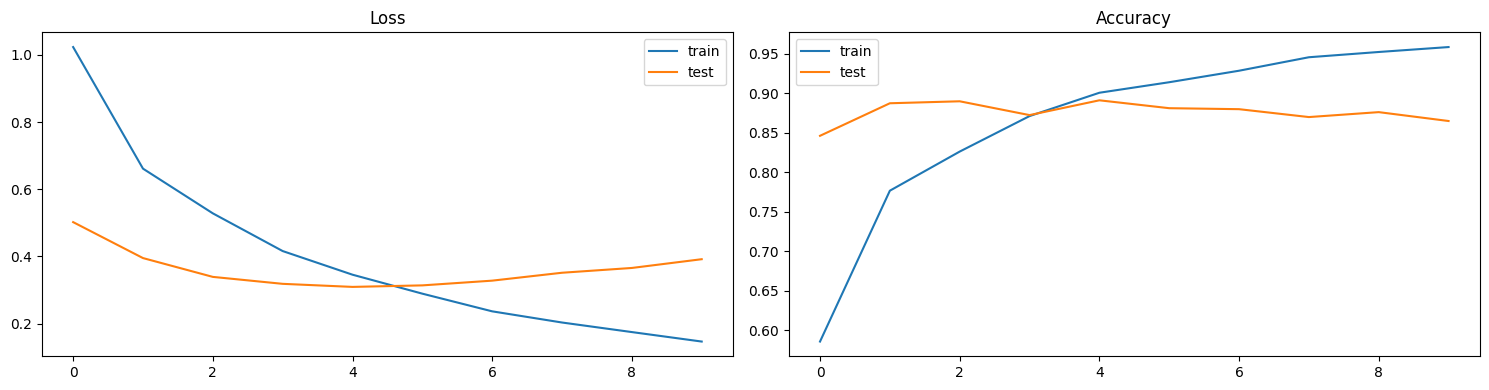

In [25]:
model_11 = load_model_test("complex_dense", history_11)

The dense model with more two more layers, and each of them has a kernel initializer. I also added drop out rate and batch normalisation after each layer. The reasons i added them are:

1. Preventing the overfitting, as we can see, the complex dense network has more smooth train and validation accuracy curve compared to the simple one before. 

2. Batch normalisation helps prevent the vanishing and exploding gradient problems and speeds up training. 

3. Kernel initializer helps to initialize the weights of the dense layer in such a way that the model converges faster and better. 

## Complex simpleRNN Model

In [ ]:
checkpoint_cb_22 = tf.keras.callbacks.ModelCheckpoint(
    "complex_simpleRNN", save_best_only=True
)

history_22 = model_22.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_cb_22]
)


13/13 [==============================] - 5s 373ms/step - loss: 1.0997 - accuracy: 0.5075
Test loss of time series: 1.10
13/13 [==============================] - 5s 372ms/step - loss: 1.0997 - accuracy: 0.5075
Test accuracy of time series: 0.51


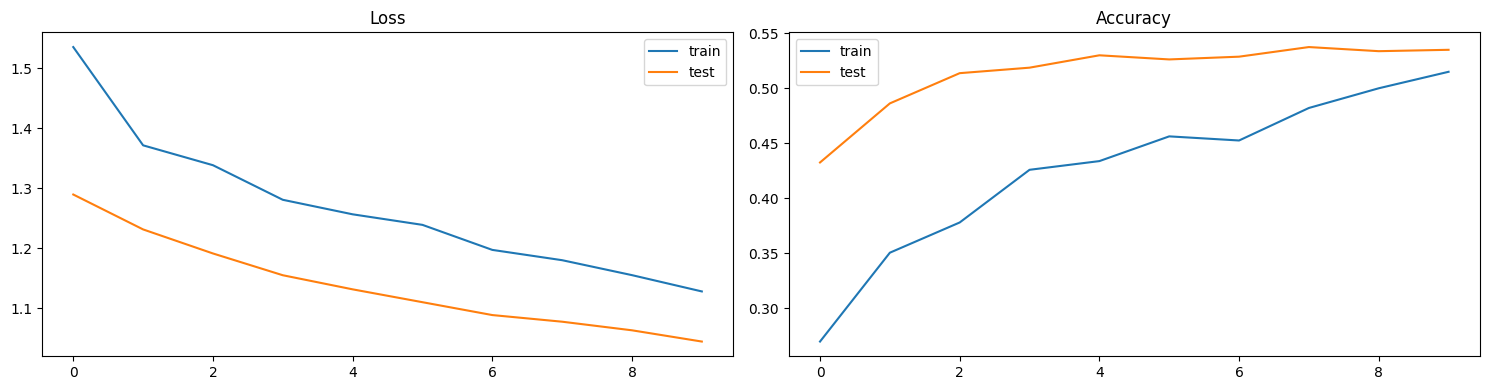

In [265]:
model_22 = load_model_test("complex_simpleRNN", history_22)

The validation accuracy of the complex simpleRNN model is higher than the previous simple one. Thus, the additiions of return_sequences=True, recurrent_dropout=0.25 and Dropout(0.3) help the network to improve a bit. Becuase the recurrent sequence allows a output of a layer to be a sequence of outputs for each input time step, rather than a single output for the entire sequence. This allows the subsequent SimpleRNN layer to also operate on the full sequence of outputs, potentially capturing more complex relationships between the input features. And the rest of two parameters prevent the overfitting for the network. The test accuracy increases from 0.49 to 0.51 here, but it is also bad. Adding more epochs might has improvement for the test accuracy.

## Complex GRU Model

In [ ]:
checkpoint_cb_33 = tf.keras.callbacks.ModelCheckpoint(
    "complex_GRU", save_best_only=True)

history_33 = model_33.fit(
    train_dataset, epochs=20, validation_data=val_dataset, callbacks=[checkpoint_cb_33]
)

13/13 [==============================] - 5s 339ms/step - loss: 1.0490 - accuracy: 0.5188
Test loss of time series: 1.05
13/13 [==============================] - 4s 319ms/step - loss: 1.0490 - accuracy: 0.5188
Test accuracy of time series: 0.52


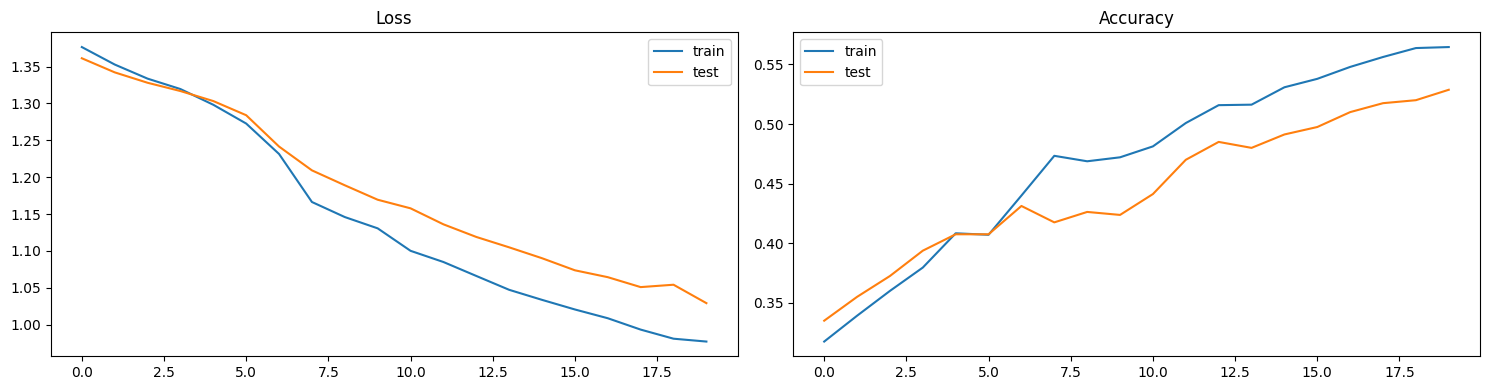

In [267]:
model_33 = load_model_test("complex_GRU", history_33)

The complex GRU increases the test accuracy from 0.42 to 0.52, but the overfitting problem is not solved.

## Complex Conv1D Model

In [54]:
checkpoint_cb_44 = tf.keras.callbacks.ModelCheckpoint(
    "complex_conv1D", save_best_only=True)

history_44 = model_44.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_cb_44]
)

Epoch 1/10
37/38 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.7779

38/38 [==============================] - 7s 108ms/step - loss: 0.6630 - accuracy: 0.7783 - val_loss: 0.3772 - val_accuracy: 0.8650
Epoch 2/10
38/38 [==============================] - 2s 50ms/step - loss: 0.2763 - accuracy: 0.9050 - val_loss: 1.4262 - val_accuracy: 0.5000
Epoch 3/10
38/38 [==============================] - 2s 49ms/step - loss: 0.2100 - accuracy: 0.9250 - val_loss: 1.1877 - val_accuracy: 0.5088
Epoch 4/10
38/38 [==============================] - 2s 49ms/step - loss: 0.1655 - accuracy: 0.9454 - val_loss: 1.1022 - val_accuracy: 0.5713
Epoch 5/10
38/38 [==============================] - 2s 49ms/step - loss: 0.1419 - accuracy: 0.9513 - val_loss: 0.9792 - val_accuracy: 0.7088
Epoch 6/10
38/38 [==============================] - 2s 50ms/step - loss: 0.1196 - accuracy: 0.9575 - val_loss: 0.9398 - val_accuracy: 0.7550
Epoch 7/10
38/38 [==============================] - 2s 49ms/step - loss: 0.0693 - accuracy: 0.9762 - val_loss: 0.7529 - val_accuracy: 0.7987
Epoch 8/10
38/38 [=====

13/13 [==============================] - 0s 16ms/step - loss: 0.3964 - accuracy: 0.8600
Test loss of time series: 0.40
13/13 [==============================] - 0s 14ms/step - loss: 0.3964 - accuracy: 0.8600
Test accuracy of time series: 0.86


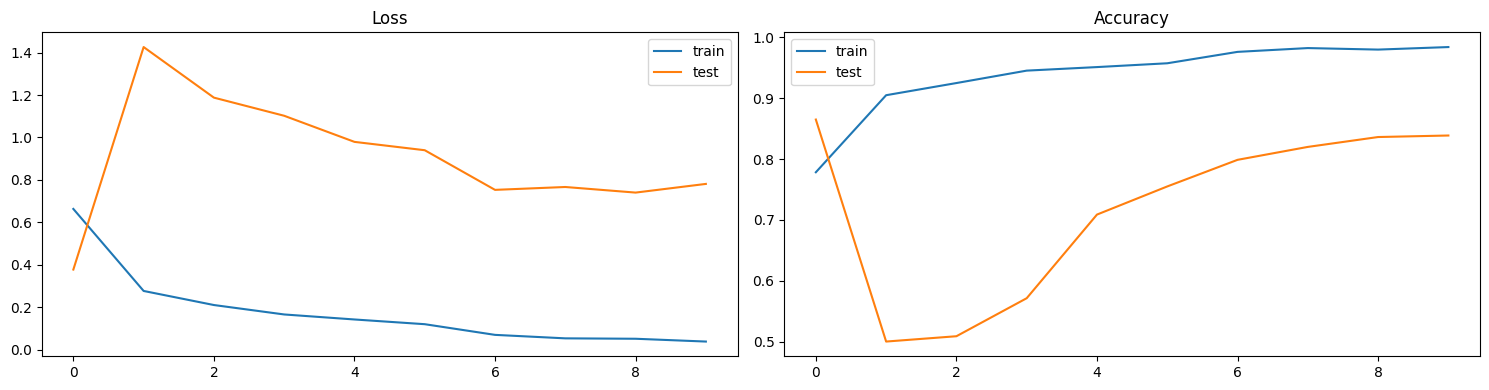

In [55]:
model_44 = load_model_test("complex_conv1D", history_44)

Two more convolutional layers, batch normalisations and drop out were added. Also, I increased the filter size for the first layer from 24 to 64. These changes improved a little bit test accuracy but the overfitting problem is still there. 

## Question 4

We have come across Conv1D layers as a tool for analyzing time series. 

Different from recurrent layers such as SimpleRNN, LSTM, or GRU, when we apply a Conv1D layer to a part of a sequence, the operation does not depend on the application of the layer to previous parts of the sequence. 

Discuss in which types of (business) applications Conv1D layers can be particularly useful, and in which you should prefer a recurrent layer.

**Conv1D Business Applications and Reasons:**

Time series analysis: 1D convolutional layers can be used to detect patterns, trends, and anomalies in time series data from diverse domains, such as finance (stock prices), healthcare (electrocardiograms). 

Specifically, 1D CNNs have recently emerged as the most advanced signal processing technique for critical signal processing applications such as patient-specific ECG classification, structural health monitoring, anomaly detection in power electronics circuitry, and motor-fault detection. 

Furthemore, similar to this turbine task, the predictive maintenance is one business application that could benefit from the use of 1D CNNs. 1D CNNs can be used in industries that rely on machinery to analyse sensor data such as vibration or temperature readings to predict when a machine is likely to fail. Using 1D CNNs for this task allows for efficient training with limited data, direct application to raw sensor data without preprocessing, and handling large datasets without overfitting. Businesses can save money by identifying and fixing potential problems before they cause machine downtime or failure.

Reference: https://ieeexplore.ieee.org/document/8682194

**RNN Business Applications and Reasons:**

Natural language generation is based on the predictive algorithms of Recurrent Neural Networks. Because the language is sequentially organised with grammar and bound into cohesion with semantics, training a model to produce generic text documents for multiple purposes is relatively simple.

Particularly, text generation is useful in business because it allows for the streamlining of workflow and the reduction of routine. Thus, that leads to conversational interfaces and chatbots which could reduce the labor cost and Improve the efficiency of solving user problems.

Specifically, conversational interfaces and chatbots is a good application of text generation. In this case, the algorithm is trained using a knowledge base and behavioural intent scenarios. A lead generation scenario, for example, is intended to gather information about a potential client, whereas a customer support scenario is intended to assist customers with product use. Conversational UI requires a sentiment analysis component in addition to text generation to correctly dissect the input message. 

Reference: https://theappsolutions.com/blog/development/recurrent-neural-networks/



## Question 5

Another, less frequently used tool for analyzing time-series data is convolutional neural networks with 2D convolutional layers. 

For this to work, time series need to be converted into “images” (matrices of numbers). 

The paper : “Convolutional neural network fault classification based on time series analysis for benchmark wind turbine machine” by Rahimilarki, Gao, Jin, and Zhang (published 2022 in “Renewable Energy” and available through the City-library)

describes how two-dimensional CNNs can be applied to the problem at hand. **Consider sections 4 and 5 which depict the process of converting one or multiple time series into “images” used within a CNN.**

In your own words, explain why the approach outlined here can help analyze time-series data and why it might outperform RNNs.

##Answer

Adding extra convolutional layers to CNN structures increases the network's nonlinearity. This increased nonlinearity allows the model to better classify more complex systems and deal with problems in noisy environments. RNNs, while effective at capturing temporal dependencies, may not be as effective at dealing with highly nonlinear patterns in data.

In any convolutional layer, there are numbers of kernels, which act as filters to extract the features of the input signals. That have the ability to detect local patterns and features within the input time series data.

Also, according to the paper, increasing the number of convolutional layers and kernels can aid in dealing with high-frequency variations in the dataset. This makes the CNN-based approach more appropriate for datasets with rapidly changing patterns or abrupt shifts, which RNNs may struggle to capture accurately. 

## Question 6

Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and 

summarized in Figure 18, convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a gray- scale image). (convert each pair of actuators’ signals into one image. )


In [57]:
# Create an empty array for reshaping time series
reshaped_time_series = np.zeros((combined_data.shape[0], 100, 100, 1))

for i in range(combined_data.shape[0]):
    # reshape the time series data for each turbine into a 2D array
    time_series_1_new = combined_data_unscaled[i,:,0].reshape((100, 50))
    time_series_2_new = combined_data_unscaled[i,:,1].reshape((100, 50))
    
    # hstack to create a 2D array with shape (100, 100)
    stacked_data = np.hstack((time_series_1_new, time_series_2_new))
    
    # reshape the stacked 2D array into a 3D array of shape (100, 100, 1)
    reshaped_time_series[i] = stacked_data.reshape((100, 100, 1))

# Select the data for training, validation, and testing sets, and the sizes of each set are the same as before identified
train_data = reshaped_time_series[:train_size]
val_data = reshaped_time_series[train_size: train_size + val_size]
test_data = reshaped_time_series[train_size + val_size:]
train_labels = y[:train_size]
val_labels = y[train_size: train_size + val_size]
test_labels = y[train_size + val_size:]

reshaped_time_series.shape, train_data.shape, val_data.shape, test_data.shape

((4000, 100, 100, 1),
 (2400, 100, 100, 1),
 (800, 100, 100, 1),
 (800, 100, 100, 1))

In [58]:
# Create the training, validation, and testing datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Batch the datasets
batch_size = 64
train_dataset = train_dataset.shuffle(100).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)
val_dataset = val_dataset.prefetch(1)

train_dataset, test_dataset, train_labels.shape, test_labels.shape

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 (2400,),
 (800,))

In [35]:
train_dataset.element_spec

(TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.float64, name=None))

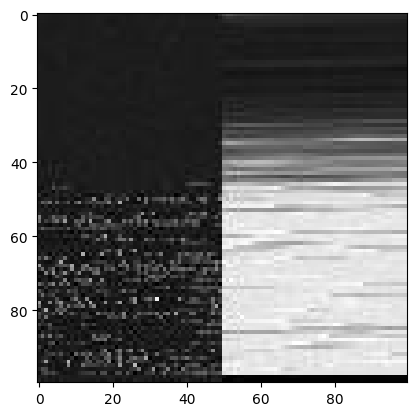

In [36]:
plt.imshow(reshaped_time_series[1], cmap = 'gray')

## Question 7

In TensorFlow, replicate the CNN with three convolutional layers displayed in Figure 12 and train it on your data. Make sure to record your final validation set accuracy.

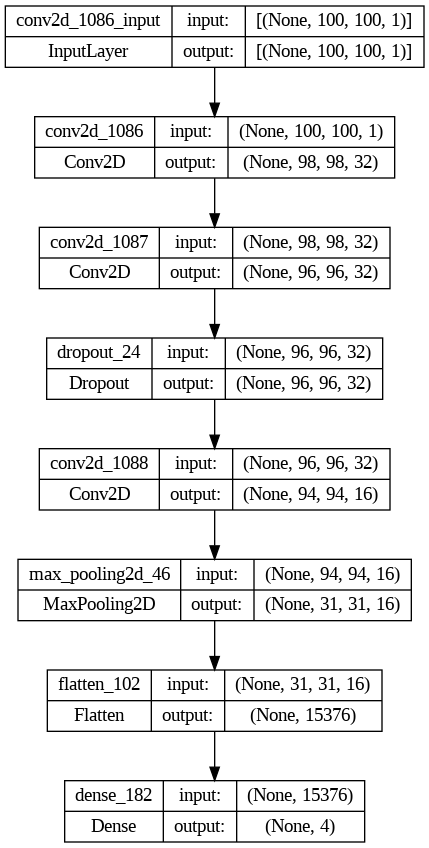

In [186]:
model_5 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=(3,3), input_shape=(100, 100,1), 
        ),

        tf.keras.layers.Conv2D(
            filters=32, kernel_size=(3,3),
        ),

        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(
            filters=16, kernel_size=(3,3), activation="relu",
        ),

        tf.keras.layers.MaxPooling2D(pool_size=3),

        tf.keras.layers.Flatten(),
       
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)

model_5.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

tf.keras.utils.plot_model(model_5, show_shapes=True)

In [212]:
checkpoint_cb_5 = tf.keras.callbacks.ModelCheckpoint(
    "conv2D.h5", save_best_only=True, monitor = 'val_accuracy', mode='max',
    )

history_5 = model_5.fit(
    train_dataset, epochs=20, validation_data=val_dataset, callbacks=[checkpoint_cb_5]
)


Epoch 1/20
38/38 [==============================] - 27s 686ms/step - loss: 0.2453 - accuracy: 0.8896 - val_loss: 0.2644 - val_accuracy: 0.8913
Epoch 2/20
38/38 [==============================] - 26s 693ms/step - loss: 0.2315 - accuracy: 0.8996 - val_loss: 0.2701 - val_accuracy: 0.8650
Epoch 3/20
38/38 [==============================] - 26s 696ms/step - loss: 0.2370 - accuracy: 0.8925 - val_loss: 0.2598 - val_accuracy: 0.8900
Epoch 4/20
38/38 [==============================] - 26s 693ms/step - loss: 0.2327 - accuracy: 0.8938 - val_loss: 0.2699 - val_accuracy: 0.8788
Epoch 5/20
38/38 [==============================] - 26s 696ms/step - loss: 0.2304 - accuracy: 0.8950 - val_loss: 0.2702 - val_accuracy: 0.8650
Epoch 6/20
38/38 [==============================] - 26s 693ms/step - loss: 0.2309 - accuracy: 0.8975 - val_loss: 0.2612 - val_accuracy: 0.8913
Epoch 7/20
38/38 [==============================] - 27s 699ms/step - loss: 0.2371 - accuracy: 0.8938 - val_loss: 0.2578 - val_accuracy: 0.8900

13/13 [==============================] - 1s 48ms/step - loss: 0.2704 - accuracy: 0.8888
Test loss of time series: 0.27
13/13 [==============================] - 1s 49ms/step - loss: 0.2704 - accuracy: 0.8888
Test accuracy of time series: 0.89


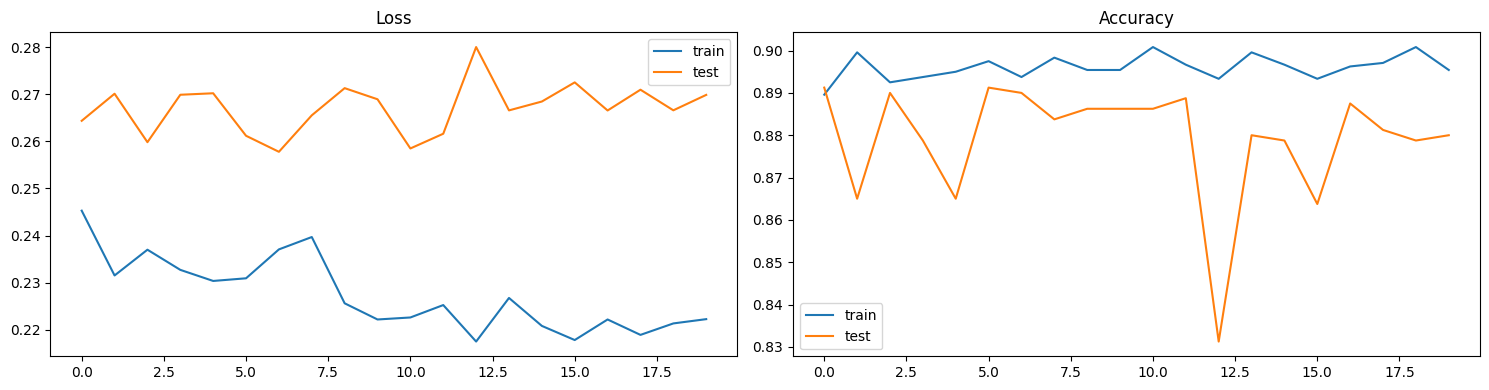

In [213]:
model_5 = load_model_test("conv2D.h5", history_5)

The replicated model has a good test accuracy. But its generalisation ability is poor which contradicts to the high test accuracy as the train accuracy is always higher than the validation accuracy. In order to improve the overfitting issues, I added one more convolutional layer and increases the filter size for the first layers. Also, adding strides and padding. Using strides 2 can cause a pooling-like effect in which the network becomes more resilient to small translations in the input data. This can help the network generalise to new data. Without padding, the filters might not cover the entire input data, potentially leading to a loss of valuable information at the borders.


## Question 8 

Model improvement

In [209]:
## Model with strides, padding and larger filters. Also, one more convolution larger is added
model_6 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=(3, 3),
            input_shape=(100, 100, 1),
            padding = "same",
            strides = 2,
        ),
     

        tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3), 
            padding = "same",
            strides = 2,
        ),
     
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3), 
            padding = "same",
            strides = 2,
        ),

          tf.keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3), 
            padding = "same",
            activation="relu",
            strides = 2,
        ),

        tf.keras.layers.MaxPooling2D(pool_size=3),

        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),       
        
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)

model_6.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model_6.summary()

Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1323 (Conv2D)        (None, 50, 50, 128)       1280      
                                                                 
 conv2d_1324 (Conv2D)        (None, 25, 25, 64)        73792     
                                                                 
 dropout_33 (Dropout)        (None, 25, 25, 64)        0         
                                                                 
 conv2d_1325 (Conv2D)        (None, 13, 13, 32)        18464     
                                                                 
 conv2d_1326 (Conv2D)        (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 2, 2, 16)         0         
 g2D)                                                            
                                                    

In [210]:
checkpoint_cb_6 = tf.keras.callbacks.ModelCheckpoint(
    "temp_conv2D_improve", save_best_only=True, monitor = 'val_accuracy', mode='max',
    )

history_6 = model_6.fit(
    train_dataset, epochs=20, validation_data=val_dataset, callbacks=[checkpoint_cb_6]
)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 4.3403 - accuracy: 0.2837

38/38 [==============================] - 10s 227ms/step - loss: 4.3403 - accuracy: 0.2837 - val_loss: 1.2889 - val_accuracy: 0.4175
Epoch 2/20
37/38 [============================>.] - ETA: 0s - loss: 1.3141 - accuracy: 0.3429

38/38 [==============================] - 5s 142ms/step - loss: 1.3140 - accuracy: 0.3438 - val_loss: 1.2124 - val_accuracy: 0.4462
Epoch 3/20
37/38 [============================>.] - ETA: 0s - loss: 1.2707 - accuracy: 0.3623

38/38 [==============================] - 5s 138ms/step - loss: 1.2701 - accuracy: 0.3604 - val_loss: 1.1605 - val_accuracy: 0.4663
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 1.2108 - accuracy: 0.3887

38/38 [==============================] - 5s 136ms/step - loss: 1.2108 - accuracy: 0.3887 - val_loss: 1.0795 - val_accuracy: 0.5063
Epoch 5/20
37/38 [============================>.] - ETA: 0s - loss: 1.1409 - accuracy: 0.4274

38/38 [==============================] - 5s 140ms/step - loss: 1.1414 - accuracy: 0.4271 - val_loss: 1.0127 - val_accuracy: 0.5337
Epoch 6/20
37/38 [============================>.] - ETA: 0s - loss: 1.0229 - accuracy: 0.5148

38/38 [==============================] - 5s 136ms/step - loss: 1.0228 - accuracy: 0.5158 - val_loss: 0.8284 - val_accuracy: 0.8087
Epoch 7/20
37/38 [============================>.] - ETA: 0s - loss: 0.8998 - accuracy: 0.6410

38/38 [==============================] - 5s 136ms/step - loss: 0.8990 - accuracy: 0.6413 - val_loss: 0.7313 - val_accuracy: 0.8238
Epoch 8/20
38/38 [==============================] - 4s 97ms/step - loss: 0.8317 - accuracy: 0.6812 - val_loss: 0.6233 - val_accuracy: 0.7937
Epoch 9/20
37/38 [============================>.] - ETA: 0s - loss: 0.7425 - accuracy: 0.7213

38/38 [==============================] - 5s 132ms/step - loss: 0.7417 - accuracy: 0.7212 - val_loss: 0.5122 - val_accuracy: 0.8600
Epoch 10/20
38/38 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.7433

38/38 [==============================] - 5s 135ms/step - loss: 0.6594 - accuracy: 0.7433 - val_loss: 0.4385 - val_accuracy: 0.8825
Epoch 11/20
37/38 [============================>.] - ETA: 0s - loss: 0.5819 - accuracy: 0.7859

38/38 [==============================] - 5s 137ms/step - loss: 0.5814 - accuracy: 0.7858 - val_loss: 0.3730 - val_accuracy: 0.8925
Epoch 12/20
38/38 [==============================] - 3s 92ms/step - loss: 0.4923 - accuracy: 0.8146 - val_loss: 0.3121 - val_accuracy: 0.8925
Epoch 13/20
37/38 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.8395

38/38 [==============================] - 5s 132ms/step - loss: 0.4161 - accuracy: 0.8404 - val_loss: 0.2795 - val_accuracy: 0.8938
Epoch 14/20
38/38 [==============================] - 4s 95ms/step - loss: 0.3845 - accuracy: 0.8621 - val_loss: 0.2805 - val_accuracy: 0.8925
Epoch 15/20
38/38 [==============================] - 4s 99ms/step - loss: 0.3497 - accuracy: 0.8696 - val_loss: 0.2776 - val_accuracy: 0.8925
Epoch 16/20
38/38 [==============================] - 4s 96ms/step - loss: 0.3284 - accuracy: 0.8754 - val_loss: 0.2670 - val_accuracy: 0.8925
Epoch 17/20
38/38 [==============================] - 4s 98ms/step - loss: 0.3289 - accuracy: 0.8712 - val_loss: 0.2676 - val_accuracy: 0.8925
Epoch 18/20
38/38 [==============================] - 4s 100ms/step - loss: 0.3087 - accuracy: 0.8783 - val_loss: 0.2685 - val_accuracy: 0.8925
Epoch 19/20
38/38 [==============================] - 4s 103ms/step - loss: 0.3153 - accuracy: 0.8771 - val_loss: 0.2626 - val_accuracy: 0.8925
Epoch 20/20
38/

13/13 [==============================] - 0s 25ms/step - loss: 0.2846 - accuracy: 0.8913
Test loss of time series: 0.28
13/13 [==============================] - 0s 24ms/step - loss: 0.2846 - accuracy: 0.8913
Test accuracy of time series: 0.89


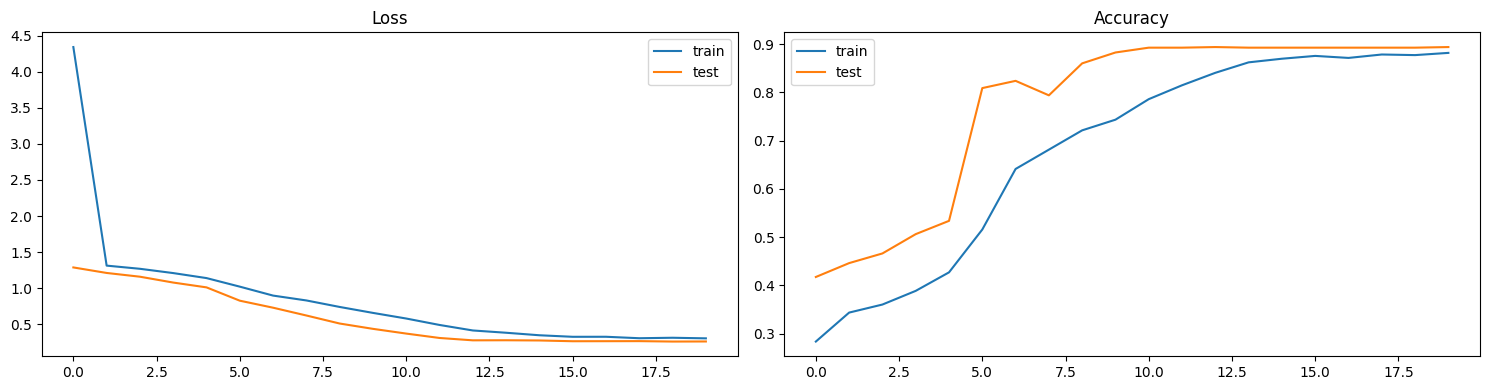

In [211]:
load_model_test("temp_conv2D_improve", history_6)

The valication accuracy is higher than the test one, implying that the improvement model has improved the overfitting problem for the previours model and the test accuracy is also good.

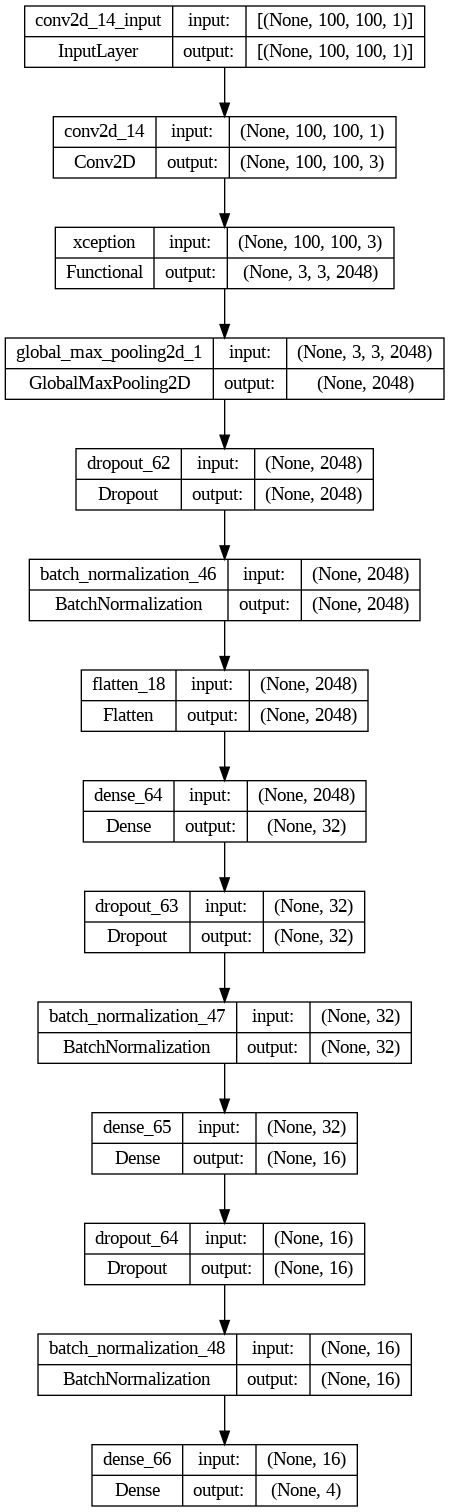

In [60]:
from tensorflow.keras.applications.xception import Xception

pre_trained_model = Xception(weights="imagenet", 
                                      input_shape=(100, 100, 3), 
                                      include_top=False)

pre_trained_model.trainable = False

pre_trained_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 3, 
                               kernel_size = 1, 
                               strides = 1, 
                               input_shape=(100, 100, 1)),
     
     
        pre_trained_model,
     
        tf.keras.layers.GlobalMaxPooling2D(),

        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
     
        tf.keras.layers.Flatten(),
     
        tf.keras.layers.Dense(32, activation="relu", kernel_initializer = "he_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
     
        tf.keras.layers.Dense(16, activation="relu", kernel_initializer = "he_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(4, activation="softmax"),
    ],

     name="pre_trained_model",
)

pre_trained_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

tf.keras.utils.plot_model(pre_trained_model, show_shapes=True)

In [61]:
checkpoint_cb_7 = tf.keras.callbacks.ModelCheckpoint(
    "pre_trained_model", save_best_only=True, monitor = 'val_accuracy', mode='max',
    )

history_7 = pre_trained_model.fit(
    train_dataset, epochs=20, validation_data=val_dataset, callbacks=[checkpoint_cb_7]
)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 1.5989 - accuracy: 0.3450

38/38 [==============================] - 29s 643ms/step - loss: 1.5989 - accuracy: 0.3450 - val_loss: 2.2723 - val_accuracy: 0.3275
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 1.3066 - accuracy: 0.4317

38/38 [==============================] - 24s 638ms/step - loss: 1.3066 - accuracy: 0.4317 - val_loss: 1.2786 - val_accuracy: 0.4363
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 1.1754 - accuracy: 0.4992

38/38 [==============================] - 25s 669ms/step - loss: 1.1754 - accuracy: 0.4992 - val_loss: 1.0395 - val_accuracy: 0.5612
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 1.1301 - accuracy: 0.5038

38/38 [==============================] - 25s 665ms/step - loss: 1.1301 - accuracy: 0.5038 - val_loss: 0.9222 - val_accuracy: 0.6500
Epoch 5/20
38/38 [==============================] - ETA: 0s - loss: 1.0467 - accuracy: 0.5321

38/38 [==============================] - 24s 649ms/step - loss: 1.0467 - accuracy: 0.5321 - val_loss: 0.8598 - val_accuracy: 0.6900
Epoch 6/20
38/38 [==============================] - ETA: 0s - loss: 0.9885 - accuracy: 0.5733

38/38 [==============================] - 25s 667ms/step - loss: 0.9885 - accuracy: 0.5733 - val_loss: 0.8199 - val_accuracy: 0.6963
Epoch 7/20
38/38 [==============================] - ETA: 0s - loss: 0.9626 - accuracy: 0.5933

38/38 [==============================] - 25s 658ms/step - loss: 0.9626 - accuracy: 0.5933 - val_loss: 0.7785 - val_accuracy: 0.7150
Epoch 8/20
38/38 [==============================] - ETA: 0s - loss: 0.9245 - accuracy: 0.6058

38/38 [==============================] - 24s 651ms/step - loss: 0.9245 - accuracy: 0.6058 - val_loss: 0.7529 - val_accuracy: 0.7225
Epoch 9/20
38/38 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.6250

38/38 [==============================] - 25s 669ms/step - loss: 0.8929 - accuracy: 0.6250 - val_loss: 0.7180 - val_accuracy: 0.7462
Epoch 10/20
38/38 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.6283

38/38 [==============================] - 25s 657ms/step - loss: 0.8743 - accuracy: 0.6283 - val_loss: 0.6952 - val_accuracy: 0.7500
Epoch 11/20
38/38 [==============================] - ETA: 0s - loss: 0.8681 - accuracy: 0.6421

38/38 [==============================] - 25s 672ms/step - loss: 0.8681 - accuracy: 0.6421 - val_loss: 0.6682 - val_accuracy: 0.7688
Epoch 12/20
38/38 [==============================] - 6s 156ms/step - loss: 0.8118 - accuracy: 0.6650 - val_loss: 0.6450 - val_accuracy: 0.7675
Epoch 13/20
38/38 [==============================] - ETA: 0s - loss: 0.8423 - accuracy: 0.6604

38/38 [==============================] - 25s 669ms/step - loss: 0.8423 - accuracy: 0.6604 - val_loss: 0.6303 - val_accuracy: 0.7725
Epoch 14/20
38/38 [==============================] - ETA: 0s - loss: 0.7954 - accuracy: 0.6879

38/38 [==============================] - 25s 663ms/step - loss: 0.7954 - accuracy: 0.6879 - val_loss: 0.6136 - val_accuracy: 0.7750
Epoch 15/20
38/38 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.6800

38/38 [==============================] - 25s 661ms/step - loss: 0.7861 - accuracy: 0.6800 - val_loss: 0.5959 - val_accuracy: 0.7800
Epoch 16/20
38/38 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.6854

38/38 [==============================] - 25s 661ms/step - loss: 0.7845 - accuracy: 0.6854 - val_loss: 0.5733 - val_accuracy: 0.7950
Epoch 17/20
38/38 [==============================] - 6s 157ms/step - loss: 0.7538 - accuracy: 0.7029 - val_loss: 0.5722 - val_accuracy: 0.7900
Epoch 18/20
38/38 [==============================] - ETA: 0s - loss: 0.7655 - accuracy: 0.6921

38/38 [==============================] - 25s 676ms/step - loss: 0.7655 - accuracy: 0.6921 - val_loss: 0.5499 - val_accuracy: 0.8012
Epoch 19/20
38/38 [==============================] - 6s 153ms/step - loss: 0.7348 - accuracy: 0.7088 - val_loss: 0.5410 - val_accuracy: 0.7950
Epoch 20/20
38/38 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.7175

38/38 [==============================] - 25s 662ms/step - loss: 0.7027 - accuracy: 0.7175 - val_loss: 0.5238 - val_accuracy: 0.8138


13/13 [==============================] - 2s 53ms/step - loss: 0.5301 - accuracy: 0.8087
Test loss of time series: 0.53
13/13 [==============================] - 1s 51ms/step - loss: 0.5301 - accuracy: 0.8087
Test accuracy of time series: 0.81


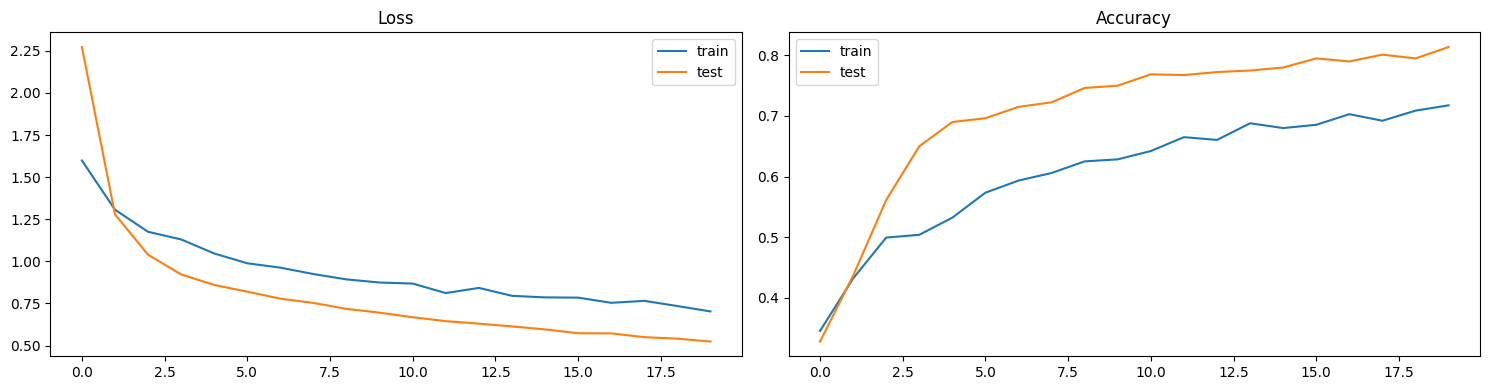

In [62]:
load_model_test("pre_trained_model", history_7)


The pre-trained model Xception is not good for this task, as it works better for 3 channel image data. However, it provides a good generalised model as the validation loss and accuracy are both better than the test one.

## Question 9

Compare the models you have created so far and select the best model (making sure to justify this). 

Train that model on a combined training and validation set and evaluate it on your test set. Make sure to record your final test accuracy.

So far the improved conv2D model is the best model compared to the rest of them. Because, it has a better generalisation ability than others, and a good test accuracy 0.89. Also, this mode is a modification of the replicated model suggest by the paper(Question 7) which means it is suitable for the turbine task. 